In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import operator
import unicodedata
import string
from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
# import xgboost as xgb
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

/Users/seanleong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# EDA

In [2]:
df = pd.read_csv('sephora_review_db.csv.zip')

In [3]:
df.shape

(276072, 22)

Columns of interest based on the below columns include: 'brand', 'name', 'brand_id', 'brand_image_url', 'product_id', 'rating', 'skin_type', 'eye_color', 'skin_concerns', 'skin_tone', 'age', 'review_text', 'price', 'recommended', 'description'

In [4]:
df.columns

Index(['brand', 'name', 'brand_id', 'brand_image_url', 'product_id',
       'product_image_url', 'rating', 'skin_type', 'eye_color',
       'skin_concerns', 'incentivized_review', 'skin_tone', 'age',
       'beauty_insider', 'user_name', 'review_text', 'price', 'recommended',
       'first_submission_date', 'last_submission_date', 'location',
       'description'],
      dtype='object')

Check to see how many missing values there are in the data

In [5]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

In [6]:
missing_zero_values_table(df)

Your selected dataframe has 22 columns and 276072 Rows.
There are 10 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
skin_concerns,0,205155,74.3,205155,74.3,object
incentivized_review,75375,196593,71.2,271968,98.5,object
recommended,17083,194300,70.4,211383,76.6,object
beauty_insider,0,165061,59.8,165061,59.8,object
location,0,162276,58.8,162276,58.8,object
age,0,156495,56.7,156495,56.7,object
skin_type,0,141630,51.3,141630,51.3,object
eye_color,0,98497,35.7,98497,35.7,object
skin_tone,0,93144,33.7,93144,33.7,object
user_name,0,2943,1.1,2943,1.1,object


In [7]:
df['skin_concerns'].value_counts()

acne               37539
aging              11881
blackheads          6075
darkCircles         5576
redness             2503
dullness            2088
unevenSkinTones     1619
sensitivity         1525
cellulite            635
sunDamage            547
pores                506
stretchMarks         141
cuticles             138
calluses             124
puffiness             20
Name: skin_concerns, dtype: int64

**Based on the above zero values table, I will drop NA values from my model, namely in the following columns: 'recommended', 'skin_type'**

In [8]:
'''check what kind of values are in the description. Some ingredient names are featured in the 
marketing/description of the product '''

# df['description'].unique()

'check what kind of values are in the description. Some ingredient names are featured in the \nmarketing/description of the product '

In [9]:
# # number of reviwers who recommeded products by rating
# recom_groups = df.groupby(['rating', 'recommended']).count()['review_text']
# recom_groups

In [10]:
# recom_groups.plot(kind='bar', stacked=False)

It would be interesting to see what the average rating is by brand

In [11]:
# average brand ratings 
brand_ratings = df.groupby(['brand']).mean()['rating'].reset_index()
brand_ratings.sort_values('rating', inplace=True)
brand_ratings.head()

,brand,rating
13,DERMAdoctor,3.428571
1,Anastasia Beverly Hills,3.470391
33,LAWLESS,3.595238
42,Natasha Denona,3.613497
23,HUDA BEAUTY,3.674705


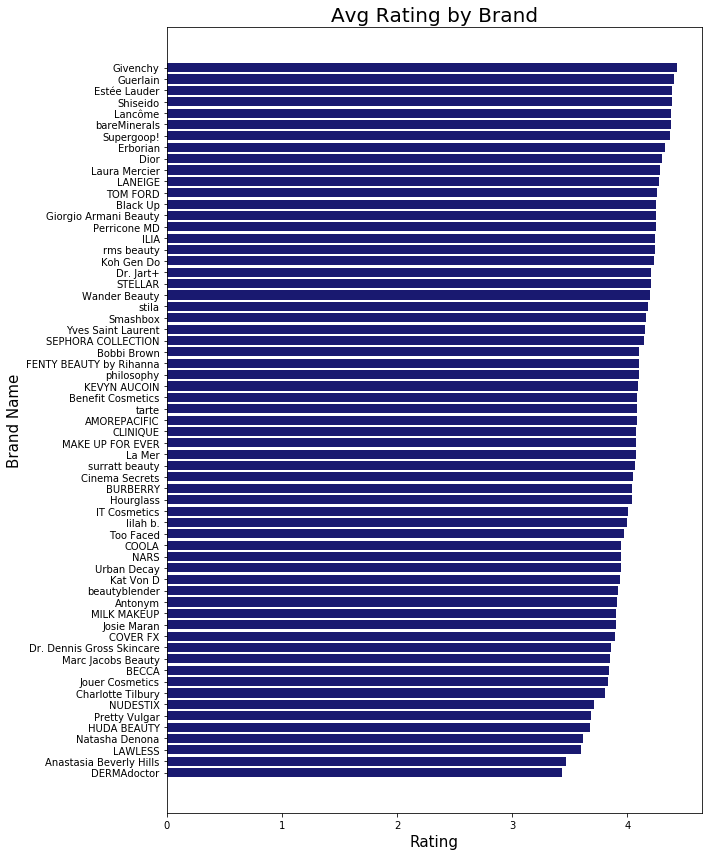

In [69]:
# plot brand and rating to see which brands have higher ratings
fig, ax = plt.subplots(figsize=(10,12))

ax.barh(brand_ratings['brand'], brand_ratings['rating'], color='midnightblue')
plt.title('Avg Rating by Brand', fontsize=20)
ax.set_xlabel('Rating', fontsize=15)
ax.set_ylabel('Brand Name', fontsize=15)
plt.tight_layout();

In [13]:
# number of reviews by brand
num_of_reviews_brand = df.groupby('brand').nunique()['review_text'].reset_index()
num_of_reviews_brand.sort_values('review_text', inplace=True)
num_of_reviews_brand.head()

# brand_price = df.groupby(['brand']).mean()['price'].reset_index()
# brand_price.sort_values('price', inplace=True)
# brand_price.head()


,brand,review_text
44,Pretty Vulgar,19
15,Dr. Dennis Gross Skincare,35
12,Cinema Secrets,39
57,lilah b.,39
31,Koh Gen Do,39


Are the highest rated brands also the brands with the highest number of reviews? It looks like this isn't the case. BareMinerals has the high number of reviews, but has the 6th highest average rating for its products.

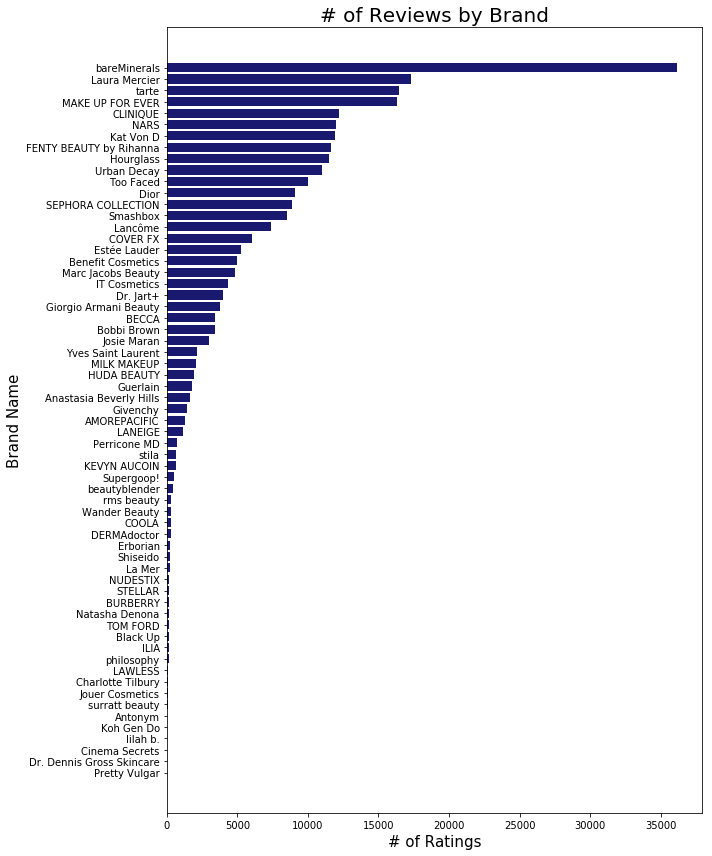

In [70]:
# plot brand and # of reviews to see most reviewed brands
fig, ax = plt.subplots(figsize=(10,12))

ax.barh(num_of_reviews_brand['brand'], num_of_reviews_brand['review_text'], color='midnightblue')
plt.title('# of Reviews by Brand', fontsize=20)
ax.set_xlabel('# of Ratings', fontsize=15)
ax.set_ylabel('Brand Name', fontsize=15)
plt.tight_layout();

In [15]:
# count number of products per brand
num_prod = df.groupby('brand').nunique()['product_id'].reset_index()
num_prod.sort_values('product_id', inplace=True)
num_prod.head()

,brand,product_id
31,Koh Gen Do,1
23,HUDA BEAUTY,1
61,surratt beauty,1
33,LAWLESS,1
19,FENTY BEAUTY by Rihanna,1


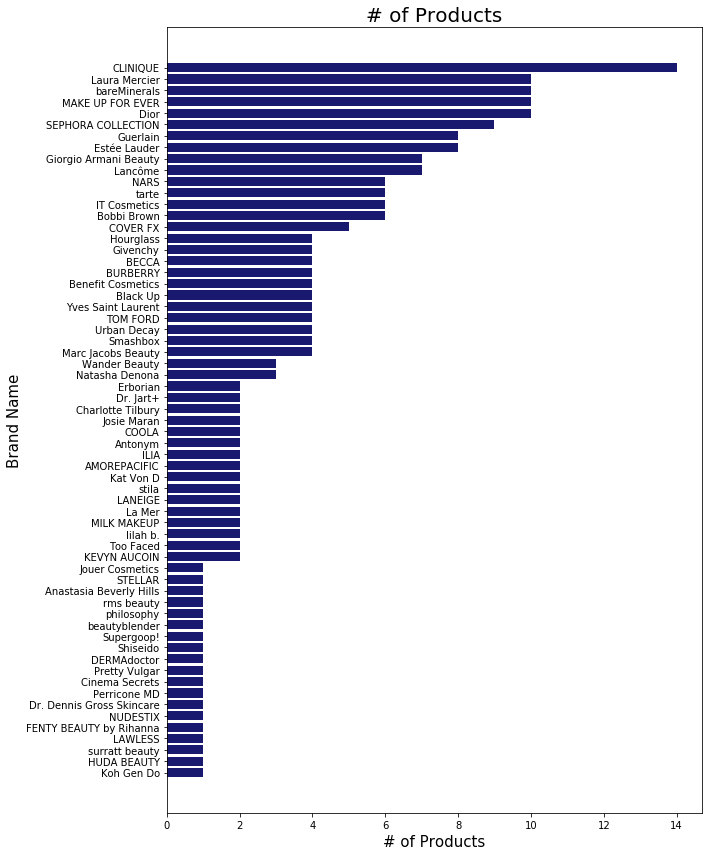

In [62]:
# plot brand and # of products per brand
fig, ax = plt.subplots(figsize=(10,12))

ax.barh(num_prod['brand'], num_prod['product_id'], color='midnightblue')
plt.title('# of Products', fontsize=20)
ax.set_xlabel('# of Products', fontsize=15)
ax.set_ylabel('Brand Name', fontsize=15)
plt.tight_layout();

In [65]:
# create simple bar graphs by 1 group
def plot_skin(df, group, count_by):
    fig, ax = plt.subplots()
    skin_type_groups = df.groupby(group).count()[count_by]
    skin_type_groups.sort_values(ascending=False).plot(kind='bar', figsize=(10,7), color='midnightblue')
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='both', labelsize=10)
    

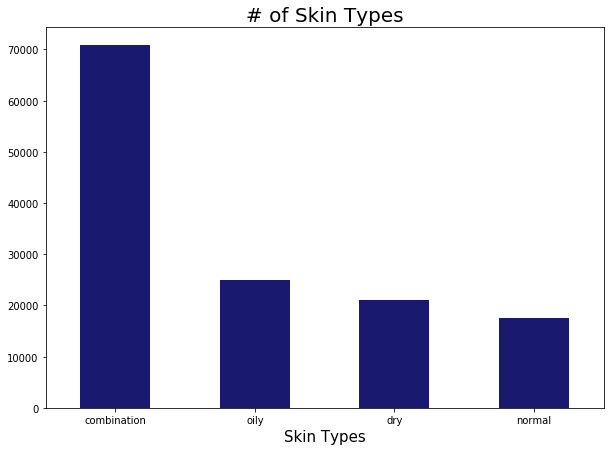

In [66]:
# Number of people with certain skin type
plot_skin(df, 'skin_type', 'review_text')
plt.xlabel('Skin Types', fontsize=15)
plt.title('# of Skin Types', fontsize=20);

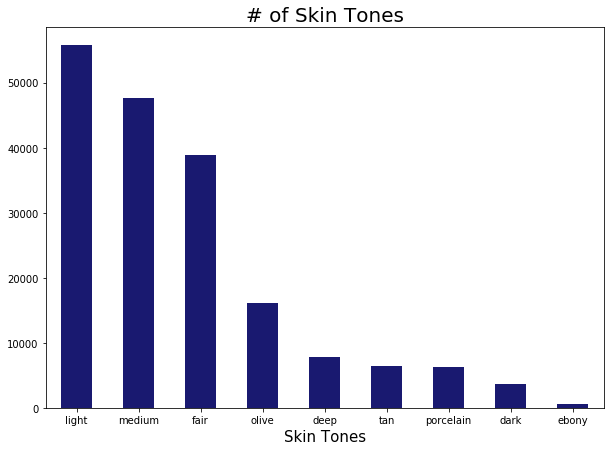

In [67]:
# number of people with different types of skin tones
plot_skin(df, 'skin_tone', 'review_text')
plt.xlabel('Skin Tones', fontsize=15)
plt.title('# of Skin Tones', fontsize=20);

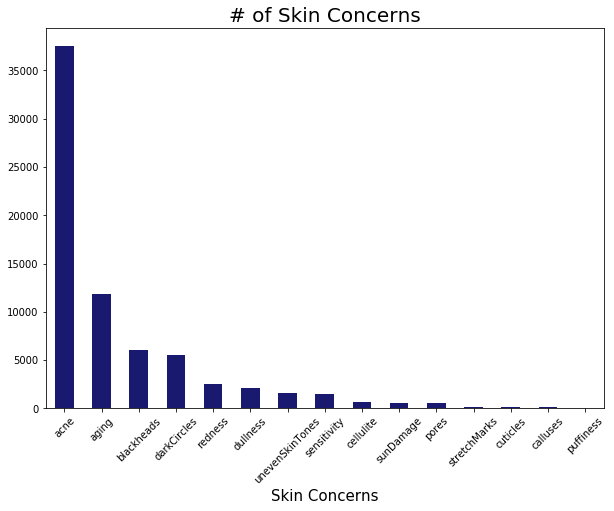

In [68]:
# number of people with different types of skin concerns
plot_skin(df, 'skin_concerns', 'review_text')
plt.xlabel('Skin Concerns', fontsize=15)
plt.xticks(rotation=45)
plt.title('# of Skin Concerns', fontsize=20);

In [21]:
df.head()

,brand,name,brand_id,brand_image_url,product_id,product_image_url,rating,skin_type,eye_color,skin_concerns,...,age,beauty_insider,user_name,review_text,price,recommended,first_submission_date,last_submission_date,location,description
0,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,4,oily,brown,acne,...,NaN,NaN,serena2304,Really good foundation I like it a lot but som...,$34.00,True,2018-01-06T01:04:26.000+00:00,2018-12-08T05:44:51.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."
1,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,5,combination,brown,acne,...,NaN,NaN,emilyrerwin,"As someone who is very VERY fair, I have alway...",$34.00,True,2018-10-19T00:29:37.000+00:00,2018-12-07T15:16:13.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."
2,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,5,combination,brown,darkCircles,...,NaN,NaN,BrowniexVixen,First purchase of a foundation of any kind. Wa...,$34.00,True,2018-02-05T21:40:40.000+00:00,2018-12-08T19:07:33.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."
3,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,5,combination,brown,acne,...,NaN,NaN,KoKoDior,I absolutely love this foundation! I get compl...,$34.00,True,2018-05-09T00:32:04.000+00:00,2018-12-03T09:54:03.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."
4,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,5,combination,green,darkCircles,...,NaN,NaN,kristaloveee,Love this foundation! I was using Too Faced Bo...,$34.00,True,2018-12-03T00:40:58.000+00:00,2018-12-06T02:32:21.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."


## Create dataframe with no NAs

**This dataset will be used for modelling**

In [22]:
df_no_na = df.dropna(subset=['skin_concerns', 'skin_tone', 'skin_type'])
df_no_na.shape

(70722, 22)

In [23]:
missing_zero_values_table(df_no_na)

Your selected dataframe has 22 columns and 70722 Rows.
There are 6 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
incentivized_review,0,70722,100.0,70722,100.0,object
beauty_insider,0,70722,100.0,70722,100.0,object
location,0,70722,100.0,70722,100.0,object
age,0,65351,92.4,65351,92.4,object
eye_color,0,1243,1.8,1243,1.8,object
user_name,0,329,0.5,329,0.5,object


In [24]:
df_no_na.head()

,brand,name,brand_id,brand_image_url,product_id,product_image_url,rating,skin_type,eye_color,skin_concerns,...,age,beauty_insider,user_name,review_text,price,recommended,first_submission_date,last_submission_date,location,description
0,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,4,oily,brown,acne,...,NaN,NaN,serena2304,Really good foundation I like it a lot but som...,$34.00,True,2018-01-06T01:04:26.000+00:00,2018-12-08T05:44:51.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."
1,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,5,combination,brown,acne,...,NaN,NaN,emilyrerwin,"As someone who is very VERY fair, I have alway...",$34.00,True,2018-10-19T00:29:37.000+00:00,2018-12-07T15:16:13.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."
2,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,5,combination,brown,darkCircles,...,NaN,NaN,BrowniexVixen,First purchase of a foundation of any kind. Wa...,$34.00,True,2018-02-05T21:40:40.000+00:00,2018-12-08T19:07:33.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."
3,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,5,combination,brown,acne,...,NaN,NaN,KoKoDior,I absolutely love this foundation! I get compl...,$34.00,True,2018-05-09T00:32:04.000+00:00,2018-12-03T09:54:03.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."
4,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,5,combination,green,darkCircles,...,NaN,NaN,kristaloveee,Love this foundation! I was using Too Faced Bo...,$34.00,True,2018-12-03T00:40:58.000+00:00,2018-12-06T02:32:21.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."


In [25]:
df_no_na['recommended'] = np.where((df_no_na['recommended'] == True), 1, 0)

/Users/seanleong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
df_no_na['price'].unique()

array(['$34.00', '$19.00 - $43.00', '$42.00 - $64.00', '$42.00',
       '$15.00 - $38.00', '$39.00', '$47.00', '$40.00', '$29.00',
       '$18.00 - $35.00', '$24.00 - $45.00', '$62.00', '$30.00', '$46.00',
       '$45.00', '$20.00', '$49.00', '$64.00', '$38.00', '$48.00',
       '$52.00', '$36.00', '$43.00', '$22.00', '$54.00', '$55.00',
       '$14.00 - $37.00', '$56.00', '$15.00 - $60.00', '$44.00', '$35.00',
       '$87.00', '$18.00', '$63.00', '$37.00', '$50.00', '$120.00',
       '$27.00', '$32.00', '$82.00', '$51.00', '$53.00',
       '$15.00 - $28.00', '$50.00 - $52.00', '$10.00 - $29.00', '$39.50',
       '$25.00', '$67.00', '$65.00', '$41.50', '$58.00',
       '$20.00 - $36.00', '$22.00 - $60.00', '$70.00', '$60.00', '$43.50',
       '$10.00', '$47.00 - $49.00', '$28.00', '$69.00', '$24.00',
       '$14.00', '$45.00 - $50.00', '$42.00 - $43.00', '$6.00'],
      dtype=object)

In [27]:
# convert price column from string to float, replace any range prices with mean price
df_no_na['price'] = df_no_na['price'].replace({'$19.00 - $43.00': '31.0'})
df_no_na['price'] = df_no_na['price'].replace({'$42.00 - $64.00': '53.0'})
df_no_na['price'] = df_no_na['price'].replace({'$15.00 - $38.00': '26.5'})
df_no_na['price'] = df_no_na['price'].replace({'$24.00 - $45.00': '34.5'})
df_no_na['price'] = df_no_na['price'].replace({'$14.00 - $37.00': '25.5'})
df_no_na['price'] = df_no_na['price'].replace({'$15.00 - $60.00': '37.5'})
df_no_na['price'] = df_no_na['price'].replace({'$15.00 - $28.00': '21.5'})
df_no_na['price'] = df_no_na['price'].replace({'$50.00 - $52.00': '51.0'})
df_no_na['price'] = df_no_na['price'].replace({'$10.00 - $29.00': '19.5'})
df_no_na['price'] = df_no_na['price'].replace({'$20.00 - $36.00': '28.0'})
df_no_na['price'] = df_no_na['price'].replace({'$22.00 - $60.00': '28.0'})
df_no_na['price'] = df_no_na['price'].replace({'$20.00 - $36.00': '41.0'})
df_no_na['price'] = df_no_na['price'].replace({'$47.00 - $49.00': '48.0'})
df_no_na['price'] = df_no_na['price'].replace({'$45.00 - $50.00': '47.5'})
df_no_na['price'] = df_no_na['price'].replace({'$42.00 - $43.00': '42.5'})
df_no_na['price'] = df_no_na['price'].replace({'$18.00 - $35.00': '26.5'})


df_no_na['price'] = df_no_na['price'].apply(lambda x: x.replace('$',''))
df_no_na['price'] = df_no_na['price'].astype(float)

type(df_no_na['price'].iloc[0])

/Users/seanleong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/seanleong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/seanleong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

numpy.float64

In [28]:
# average brand ratings 
brand_ratings = df.groupby(['brand']).mean()['rating'].reset_index()
brand_ratings.sort_values('rating', inplace=True)
brand_ratings.head()

,brand,rating
13,DERMAdoctor,3.428571
1,Anastasia Beverly Hills,3.470391
33,LAWLESS,3.595238
42,Natasha Denona,3.613497
23,HUDA BEAUTY,3.674705


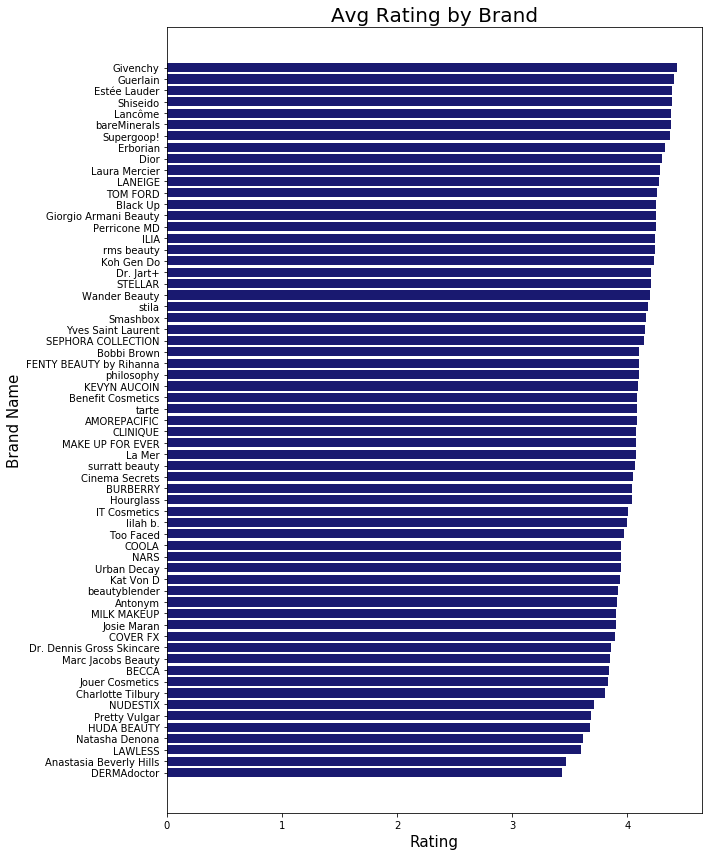

In [71]:
# plot brand and rating to see which brands have higher ratings
fig, ax = plt.subplots(figsize=(10,12))

ax.barh(brand_ratings['brand'], brand_ratings['rating'], color='midnightblue')
plt.title('Avg Rating by Brand', fontsize=20)
ax.set_xlabel('Rating', fontsize=15)
ax.set_ylabel('Brand Name', fontsize=15)
plt.tight_layout();

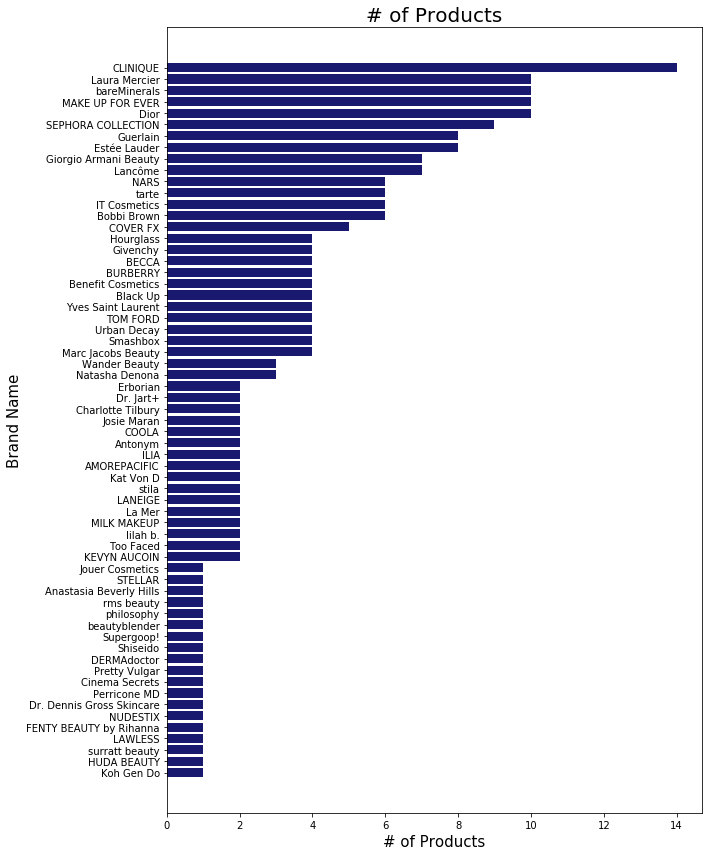

In [72]:
# number of reviews by brand
num_of_reviews_brand = df.groupby('brand').nunique()['review_text'].reset_index()
num_of_reviews_brand.sort_values('review_text', inplace=True)
# num_of_reviews_brand.head()

# plot brand and # of products per brand
fig, ax = plt.subplots(figsize=(10,12))

ax.barh(num_prod['brand'], num_prod['product_id'], color='midnightblue')
plt.title('# of Products', fontsize=20)
ax.set_xlabel('# of Products', fontsize=15)
ax.set_ylabel('Brand Name', fontsize=15)
plt.tight_layout();

In [73]:
# create simple bar graphs by 1 group
def plot_skin(df, group, count_by):
    fig, ax = plt.subplots()
    skin_type_groups = df.groupby(group).count()[count_by]
    skin_type_groups.sort_values(ascending=False).plot(kind='bar', figsize=(10,7), color='midnightblue')
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='both', labelsize=10)

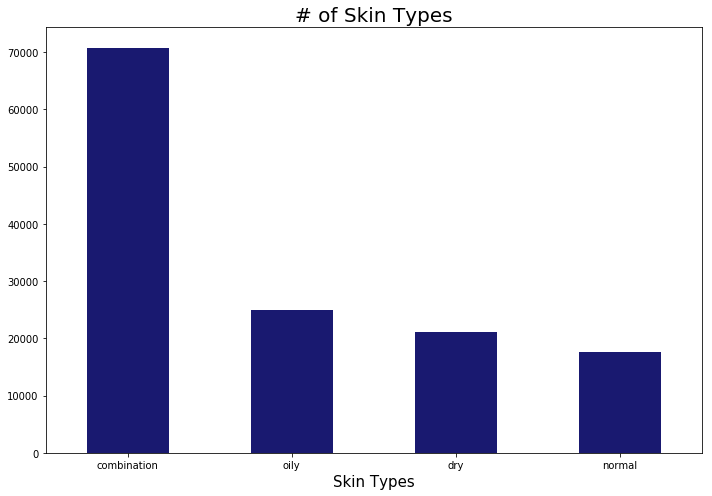

In [74]:
# Number of people with certain skin type
plot_skin(df, 'skin_type', 'review_text')
plt.xlabel('Skin Types', fontsize=15)
plt.title('# of Skin Types', fontsize=20)
plt.tight_layout()
plt.savefig('imgs/skin_types.png');

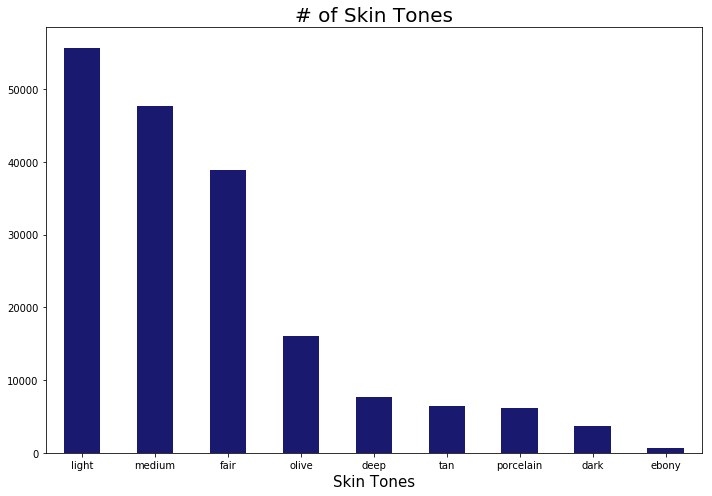

In [75]:
# number of people with different types of skin tones
plot_skin(df, 'skin_tone', 'review_text')
plt.xlabel('Skin Tones', fontsize=15)
plt.title('# of Skin Tones', fontsize=20)
plt.tight_layout()
plt.savefig('imgs/skin_tones.png');

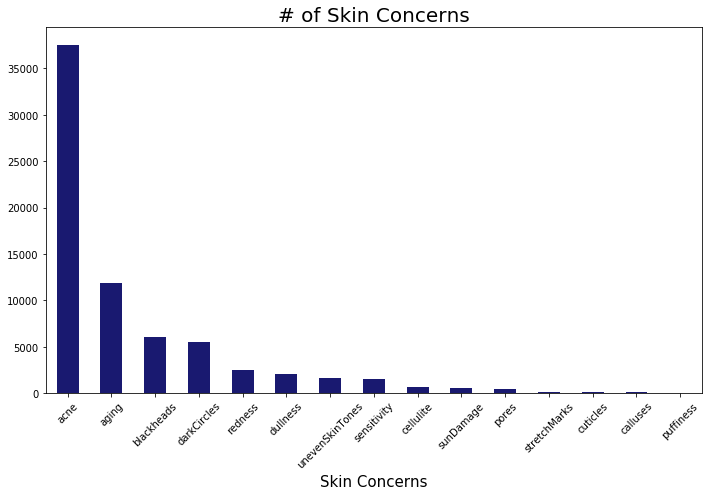

In [76]:
# number of people with different types of skin concerns
plot_skin(df, 'skin_concerns', 'review_text')
plt.xlabel('Skin Concerns', fontsize=15)
plt.xticks(rotation=45)
plt.title('# of Skin Concerns', fontsize=20)
plt.tight_layout()
plt.savefig('imgs/skin_concerns.png');

In [77]:
# plot distribution by outcome categories
def plot_histograms_by_outcome(x, y):
    plt.hist(list(x[y==0]), alpha=0.5, label='Recommended=0', color='blue')
    plt.hist(list(x[y==1]), alpha=0.5, label='Recommended=1', color='midnightblue')
    plt.title('Histogram of {}'.format(x.name), fontsize=20)
    plt.xlabel('')
    plt.legend()

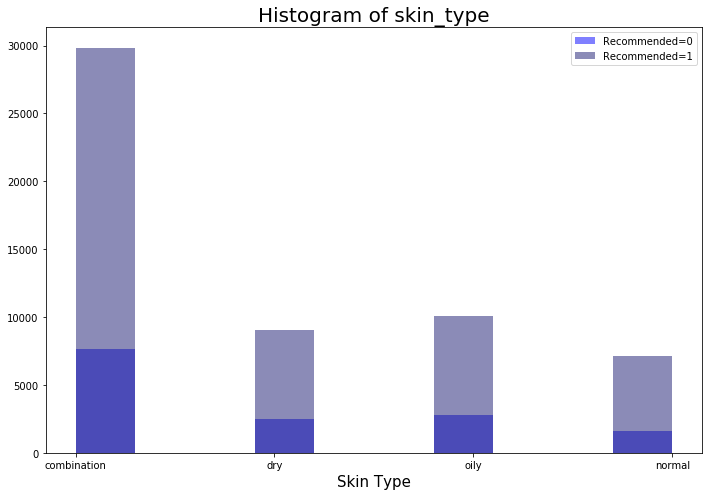

In [81]:
fig, ax = plt.subplots(figsize=(10,7))
plot_histograms_by_outcome(df_no_na['skin_type'], df_no_na['recommended'])
plt.xlabel('Skin Type', fontsize=15)
plt.tight_layout()
plt.savefig('imgs/skin_type_rec.png')

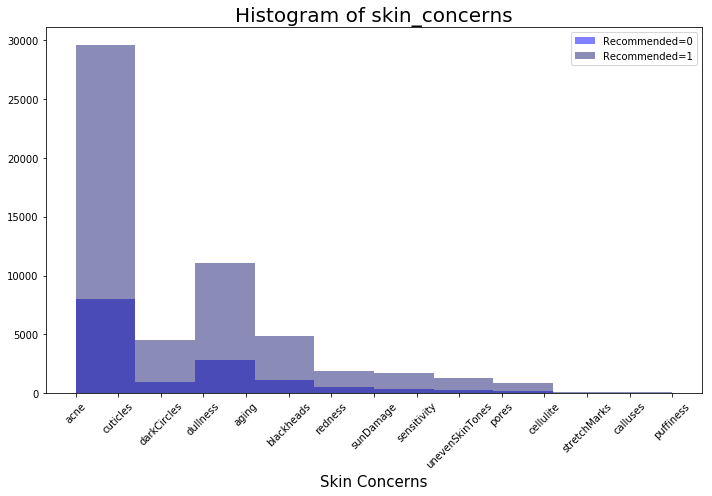

In [79]:
fig, ax = plt.subplots(figsize=(10,7))
plot_histograms_by_outcome(df_no_na['skin_concerns'], df_no_na['recommended'])
plt.xlabel('Skin Concerns', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('imgs/skin_concern_rec.png');

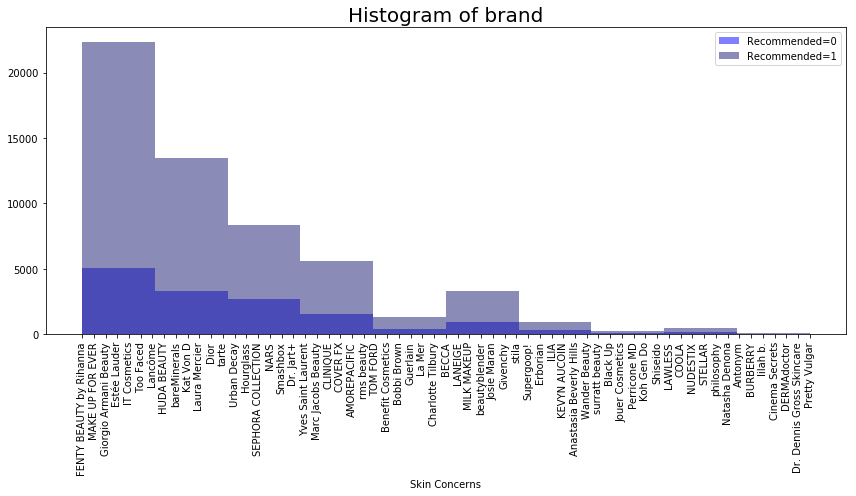

In [80]:
fig, ax = plt.subplots(figsize=(12,7))
plot_histograms_by_outcome(df_no_na['brand'], df_no_na['recommended'])
plt.xlabel('Skin Concerns', fontsize=10)
plt.xticks(rotation=90)
plt.tight_layout();